**polya tail length in PacBio and Nanopore data**

In [288]:
from collections import defaultdict, namedtuple, Counter
import pickle
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import pyranges as pr
import pysam
from scipy.stats import variation, gaussian_kde, pearsonr, mannwhitneyu

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(filename)s: %(message)s',
                    datefmt='%m/%d/%Y %I:%M:%S %p',
                    )

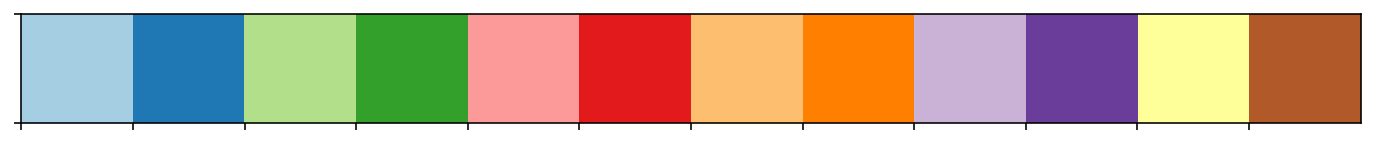

In [289]:
# 加载画图包
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import seaborn as sns

# 设置全局字体
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

# setting color palette
pal = sns.color_palette("Paired")
sns.set_palette(pal)
sns.palplot(pal)

# load gene model

In [4]:
gene_model_bed = '/public/home/mowp/db/Arabidopsis_thaliana/isoform/araport11.gene.bed'
gene_model = pr.read_bed(gene_model_bed, as_df=True)
gene_model = gene_model.set_index(['Name'])
gene_model.head()

,Chromosome,Start,End,Score,Strand
Name,,,,,
AT1G01010,1,3629,5899,.,+
AT1G01020,1,6786,9130,.,-
AT1G03987,1,11099,11372,.,+
AT1G01030,1,11647,13714,.,-
AT1G01040,1,23119,31227,.,+


# polya tail length

In [9]:
from scipy.stats import variation
from scipy.stats import gaussian_kde
import seaborn as sns

In [5]:
STRAND_TO_BOOL = {'-': True, '+': False}
def get_polya_tail_len(infile, gene_id):
    '''
    获取基因的polya tail polya 中位数长度
    '''
    chrom, start, end, _, gene_strand = gene_model.loc[gene_id, :].values
    gene_strand = STRAND_TO_BOOL[gene_strand]
    
    polya_len_list = []
    n = 0
    with pysam.AlignmentFile(infile, 'rb') as inbam:
        for read in inbam.fetch(chrom, start, end):
            
            polya_len = read.get_tag('pa')
            gap = read.get_tag('ga')
            read_gene_id = read.get_tag('gi')
            
            if polya_len > 15 and read_gene_id == gene_id:
                polya_len_list.append(polya_len)
    
    if len(polya_len_list) >= 10:
        polya_len = np.median(polya_len_list)  # median polya len
        cv = variation(polya_len_list)  # Coefficient Of Variation
    else:
        return None
    
    return polya_len, cv, gene_id

## Nanopore data

In [8]:
# single run

infile = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.polyadenylated.bam'
gene_id = 'AT1G01010'
get_polya_tail_len(infile, gene_id)

(121.7249984741211, 0.8927265095615285, 'AT1G01010')

In [41]:
# multi run

infile = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.polyadenylated.bam'

results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in gene_model.index:
        results.append(e.submit(get_polya_tail_len, infile, gene_id))

In [42]:
polya_results = []
for res in results:
    result = res.result()
    if result is not None:
        polya_results.append(result)

In [43]:
nanopore_polya = pd.DataFrame(polya_results, columns=['polya_len', 'cv', 'gene_id'])
nanopore_polya['type'] = 'nanopore'

Text(0, 0.5, 'Gene counts')

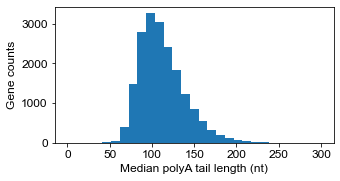

In [47]:
plt.figure(figsize=(5, 2.5))
plt.hist(nanopore_polya.polya_len, bins=np.linspace(0, 300, 30))
plt.xlabel('Median polyA tail length (nt)')
plt.ylabel('Gene counts')

In [323]:
np.percentile(nanopore_polya.polya_len, 2.5)

72.81600036621094

In [322]:
np.percentile(nanopore_polya.polya_len, 97.5)

176.5559997558594

In [95]:
nanopore_polya.to_csv('polya_length/nanopore_polya_len.tsv', sep='\t', index=False)

Text(0, 0.5, 'CV of poly(A) tail length')

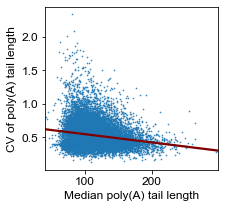

In [107]:
plt.figure(figsize=(3.1, 3))
sns.regplot(
    x="polya_len", 
    y="cv", 
    data=nanopore_polya, 
    scatter_kws={'s' :.5},
    line_kws={'color': 'maroon'},
)
plt.xlabel('Median poly(A) tail length')
plt.ylabel('CV of poly(A) tail length')

In [106]:
pearsonr(nanopore_polya['polya_len'], nanopore_polya['cv'])

(-0.18870157841463256, 1.4887661415153974e-149)

## pacbio_polya

In [282]:
# single run

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/polyadenylated_data/totalRNA.polyadenylated.bam'
gene_id = 'AT1G01010'
get_polya_tail_len(infile, gene_id)

(141.5, 1.1358355422374564, 'AT1G01010')

In [283]:
# multi run

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/polyadenylated_data/totalRNA.polyadenylated.bam'

results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in gene_model.index:
        results.append(e.submit(get_polya_tail_len, infile, gene_id))

In [284]:
polya_results = []
for res in results:
    result = res.result()
    if result is not None:
        polya_results.append(result)

In [285]:
pacbio_polya = pd.DataFrame(polya_results, columns=['polya_len', 'cv', 'gene_id'])
pacbio_polya['type'] = 'pacbio'

Text(0, 0.5, 'Gene counts')

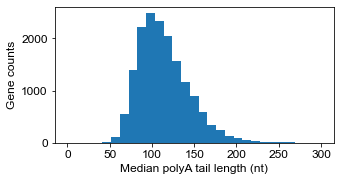

In [286]:
plt.figure(figsize=(5, 2.5))
plt.hist(pacbio_polya.polya_len, bins=np.linspace(0, 300, 30))
plt.xlabel('Median polyA tail length (nt)')
plt.ylabel('Gene counts')

In [320]:
np.percentile(pacbio_polya.polya_len, 2.5)

69.0

In [321]:
np.percentile(pacbio_polya.polya_len, 97.5)

185.0

In [287]:
pacbio_polya.to_csv('polya_length/pacbio_polya_len.tsv', sep='\t', index=False)

## nanopore and pacbio

nanopore median polya length = 107.86
pacbio median polya length = 109.00


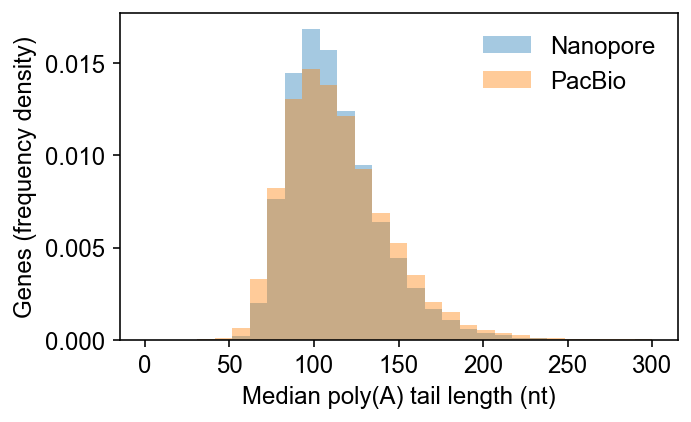

In [292]:
plt.figure(figsize=(5, 3))
sns.distplot(nanopore_polya.polya_len,
             hist=True, kde=False,
             bins=np.linspace(0, 300, 30),
             hist_kws={'density': True},
             label='Nanopore',
             color=pal[1]
            )
sns.distplot(pacbio_polya.polya_len,
             hist=True, kde=False,
             bins=np.linspace(0, 300, 30),
             hist_kws={'density': True},
             label='PacBio',
             color=pal[7]
            )

plt.legend(frameon=False)
plt.ylabel('Genes (frequency density)')
plt.xlabel('Median poly(A) tail length (nt)')


print(f'nanopore median polya length = {np.median(nanopore_polya.polya_len):.2f}')
print(f'pacbio median polya length = {np.median(pacbio_polya.polya_len):.2f}')

## nanopore direct RNA-seq

In [80]:
# single run

infile = '/public/home/mowp/data/total_RNA/direct_rna_seq_elife/polyadenylated_data/rds.full_len.bam'
gene_id = 'AT1G01010'
get_polya_tail_len(infile, gene_id)

In [81]:
# multi run

infile = '/public/home/mowp/data/total_RNA/direct_rna_seq_elife/polyadenylated_data/rds.full_len.bam'

results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in gene_model.index:
        results.append(e.submit(get_polya_tail_len, infile, gene_id))

In [82]:
polya_results = []
for res in results:
    result = res.result()
    if result is not None:
        polya_results.append(result)

In [84]:
rds_polya = pd.DataFrame(polya_results, columns=['polya_len', 'cv', 'gene_id'])
rds_polya['type'] = 'rds'

81.07499885559082


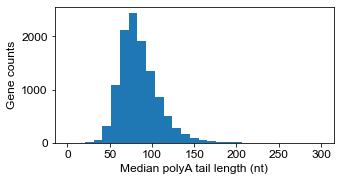

In [149]:
plt.figure(figsize=(5, 2.5))
plt.hist(rds_polya.polya_len, bins=np.linspace(0, 300, 30))
plt.xlabel('Median polyA tail length (nt)')
plt.ylabel('Gene counts')
print(np.median(rds_polya['polya_len']))

In [97]:
rds_polya.to_csv('polya_length/rds_polya_len.tsv', sep='\t', index=False)

## Nanopore vs PacBio

### boxplot and violienplot

In [156]:
df = pd.concat([nanopore_polya, pacbio_polya])

Text(0, 0.5, 'Median poly(A) tail length (nt)')

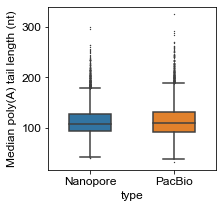

In [157]:
plt.figure(figsize=(3, 3))
sns.boxplot(x='type', y='polya_len', data=df, fliersize=.5, width=.5)
# plt.ylim(0, 1.5)
plt.xticks([0, 1], ['Nanopore', 'PacBio'])
plt.ylabel('Median poly(A) tail length (nt)')

Text(0.5, 0, '')

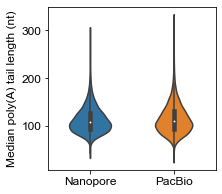

In [158]:
plt.figure(figsize=(3, 3))
sns.violinplot(x='type', y='polya_len', data=df, width=.5)
# plt.ylim(0, 1.5)
plt.xticks([0, 1], ['Nanopore', 'PacBio'])
plt.ylabel('Median poly(A) tail length (nt)')
plt.xlabel('')

In [159]:
_ = np.median(df.query('type == "nanopore"')['polya_len'])
print(f'nanopore median polya len = {_:.2f} nt')
_ = np.median(df.query('type == "pacbio"')['polya_len'])
print(f'pacbio median polya len = {_:.2f} nt')

nanopore median polya len = 107.86 nt
pacbio median polya len = 109.00 nt


### regplot

In [294]:
df = pd.merge(nanopore_polya, pacbio_polya, on='gene_id')
df

,polya_len_x,cv_x,gene_id,type_x,polya_len_y,cv_y,type_y
0,121.724998,0.892727,AT1G01010,nanopore,141.5,1.135836,pacbio
1,181.070000,0.404013,AT1G01020,nanopore,185.5,0.981497,pacbio
2,94.180000,0.443595,AT1G01030,nanopore,95.0,0.361186,pacbio
3,185.945000,0.417997,AT1G01040,nanopore,196.5,0.490877,pacbio
4,99.055000,0.715007,AT1G01050,nanopore,110.0,1.090978,pacbio
...,...,...,...,...,...,...,...
16300,89.270000,0.481350,AT5G67630,nanopore,104.0,0.484477,pacbio
16301,93.500000,0.702927,AT5G67640,nanopore,128.0,0.998522,pacbio
16302,39.500000,0.459322,ATCG00450,nanopore,31.5,0.418856,pacbio
16303,59.320000,1.065858,ATMG00020,nanopore,42.0,1.179439,pacbio


In [258]:
pearsonr(df['polya_len_x'], df['polya_len_y'])

(0.8873615833511955, 0.0)

Text(0.5, 1.0, 'Median poly(A) tail length (nt)')

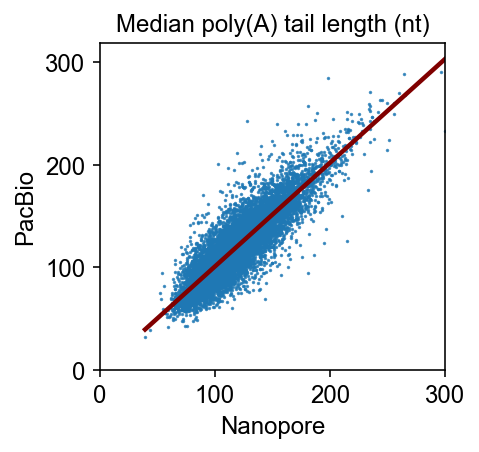

In [297]:
plt.figure(figsize=(3.1, 3))
sns.regplot(
    x="polya_len_x", 
    y="polya_len_y", 
    data=df.query('polya_len_x < 300 & polya_len_y < 300'), 
    scatter_kws={'s' :.5},
    line_kws={'color': 'maroon'},
    color=pal[1],
)
# plt.xlim(0, 300)
# plt.ylim(0, 300)
plt.xlabel('Nanopore')
plt.ylabel('PacBio')
# plt.title('Median poly(A) tail length')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])
plt.title('Median poly(A) tail length (nt)', size='medium')

In [163]:
# Calculate the point density
xy = np.vstack([df['polya_len_x'], df['polya_len_y']])
color = gaussian_kde(xy)(xy)

10/31/2020 05:01:39 PM colorbar.py: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b755e417390>
10/31/2020 05:01:39 PM colorbar.py: Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b755e417390> on colorbar
10/31/2020 05:01:39 PM colorbar.py: Setting pcolormesh


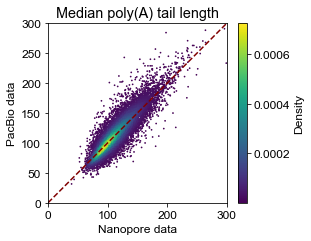

In [164]:
plt.figure(figsize=(4, 3.3))
plt.scatter(df['polya_len_x'], df['polya_len_y'], s=.5, c=color,)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.plot([0, 300], [0, 300], color='maroon', ls='--')
plt.xlabel('Nanopore data')
plt.ylabel('PacBio data')
plt.title('Median poly(A) tail length')
colorbar = plt.colorbar()
colorbar.set_label("Density")

In [165]:
# Calculate the point density
xy = np.vstack([df['cv_x'], df['cv_y']])
color = gaussian_kde(xy)(xy)

10/31/2020 05:01:51 PM colorbar.py: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b755de3ba10>
10/31/2020 05:01:51 PM colorbar.py: Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b755de3ba10> on colorbar
10/31/2020 05:01:51 PM colorbar.py: Setting pcolormesh


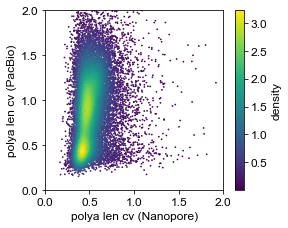

In [166]:
plt.figure(figsize=(4, 3.3))
plt.scatter(df['cv_x'], df['cv_y'], s=.5, c=color,)
plt.xlim(0, 2)
plt.ylim(0, 2)
# plt.plot([0, 2], [0, 2], color='maroon', ls='--')
plt.xlabel('polya len cv (Nanopore)')
plt.ylabel('polya len cv (PacBio)')

colorbar = plt.colorbar()
colorbar.set_label("density")

## nanopore vs RDS

(0.7120507320628084, 0.0)

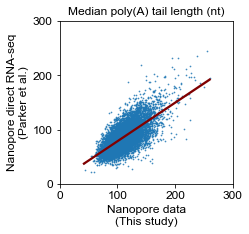

In [267]:
df = pd.merge(nanopore_polya, rds_polya, on='gene_id')
plt.figure(figsize=(3.1, 3))
sns.regplot(
    x="polya_len_x", 
    y="polya_len_y", 
    data=df, 
    scatter_kws={'s' :.5},
    line_kws={'color': 'maroon'},
)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.xlabel('Nanopore data\n(This study)')
plt.ylabel('Nanopore direct RNA-seq\n(Parker et al.)')
plt.title('Median poly(A) tail length (nt)', size='medium')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])
pearsonr(df['polya_len_x'], df['polya_len_y'])

## PacBio vs RDS

(0.684004478656068, 0.0)

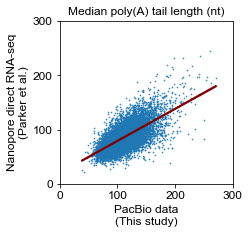

In [266]:
df = pd.merge(pacbio_polya, rds_polya, on='gene_id')
plt.figure(figsize=(3.1, 3))
sns.regplot(
    x="polya_len_x", 
    y="polya_len_y", 
    data=df, 
    scatter_kws={'s' :.5},
    line_kws={'color': 'maroon'},
)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.xlabel('PacBio data\n(This study)')
plt.ylabel('Nanopore direct RNA-seq\n(Parker et al.)')
plt.title('Median poly(A) tail length (nt)', size='medium')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])
pearsonr(df['polya_len_x'], df['polya_len_y'])

# PAL-seq: GSE52809_Arabidopsis

In [133]:
infile = '/public/home/mowp/data/total_RNA/notebook/polya_length/GSE52809_Arabidopsis.txt'
tail_seq_polya = pd.read_csv(infile, sep='\t', comment='#')
tail_seq_polya = tail_seq_polya.loc[:, ['Gene name', 'Median TL']]
tail_seq_polya.columns = ['gene_id', 'polya_len']

Text(0, 0.5, 'Gene counts')

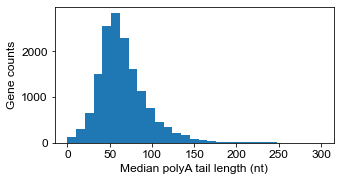

In [148]:
plt.figure(figsize=(5, 2.5))
plt.hist(tail_seq_polya.polya_len, bins=np.linspace(0, 300, 30))
plt.xlabel('Median polyA tail length (nt)')
plt.ylabel('Gene counts')

## Nanopore vs TAIL-seq

In [139]:
df = pd.merge(nanopore_polya, tail_seq_polya, on='gene_id')

In [140]:
pearsonr(df['polya_len_x'], df['polya_len_y'])

(0.4555603802833985, 0.0)

([<matplotlib.axis.YTick at 0x2b756e39f950>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

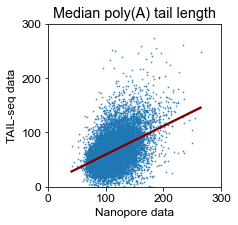

In [141]:
plt.figure(figsize=(3.1, 3))
sns.regplot(
    x="polya_len_x", 
    y="polya_len_y", 
    data=df, 
    scatter_kws={'s' :.5},
    line_kws={'color': 'maroon'},
)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.xlabel('Nanopore data')
plt.ylabel('TAIL-seq data')
plt.title('Median poly(A) tail length')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])

## direct RNA-seq vs PAL-seq

In [142]:
df = pd.merge(rds_polya, tail_seq_polya, on='gene_id')

In [143]:
pearsonr(df['polya_len_x'], df['polya_len_y'])

(0.42417250832566855, 0.0)

In [ ]:
plt.figure(figsize=(3.1, 3))
sns.regplot(
    x="polya_len_x", 
    y="polya_len_y", 
    data=df, 
    scatter_kws={'s' :.5},
    line_kws={'color': 'maroon'},
)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.xlabel('Nanopore data')
plt.ylabel('TAIL-seq data ()')
plt.title('Median poly(A) tail length')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])

## Nanopore vs PAL-seq

In [276]:
df = pd.merge(nanopore_polya, tail_seq_polya, on='gene_id')

In [277]:
pearsonr(df['polya_len_x'], df['polya_len_y'])

(0.4555603802833985, 0.0)

([<matplotlib.axis.YTick at 0x2b756e0eee50>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

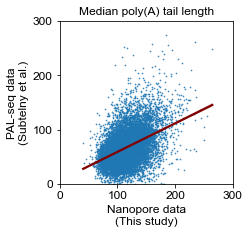

In [278]:
plt.figure(figsize=(3.1, 3))
sns.regplot(
    x="polya_len_x", 
    y="polya_len_y", 
    data=df, 
    scatter_kws={'s' :.5},
    line_kws={'color': 'maroon'},
)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.xlabel('Nanopore data\n(This study)')
plt.ylabel('PAL-seq data\n(Subtelny et al.)')
plt.title('Median poly(A) tail length', size='medium')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])

## PacBio vs PAL-seq

In [271]:
df = pd.merge(pacbio_polya, tail_seq_polya, on='gene_id')

In [272]:
pearsonr(df['polya_len_x'], df['polya_len_y'])

(0.4454519782471224, 0.0)

([<matplotlib.axis.YTick at 0x2b756e028390>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

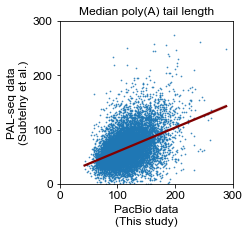

In [275]:
plt.figure(figsize=(3.1, 3))
sns.regplot(
    x="polya_len_x", 
    y="polya_len_y", 
    data=df, 
    scatter_kws={'s' :.5},
    line_kws={'color': 'maroon'},
)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.xlabel('PacBio data\n(This study)')
plt.ylabel('PAL-seq data\n(Subtelny et al.)')
plt.title('Median poly(A) tail length', size='medium')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])

# mRNA half life

In [216]:
infile = '/public/home/mowp/data/total_RNA/notebook/mRNA_half_life/TPC_Global_mRNA_Decay.tsv'
tpc_half_life = pd.read_csv(infile, sep='\t')
tpc_half_life['gene_id'] = tpc_half_life['gene_id'].str.upper()

In [217]:
df = pd.merge(nanopore_polya, tpc_half_life, on='gene_id')

In [218]:
pearsonr(df['polya_len'], df['t1/2'])

(-0.17720752802697004, 5.032184207039766e-86)

([<matplotlib.axis.XTick at 0x2b7493456d10>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

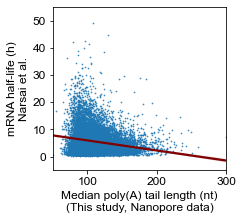

In [219]:
plt.figure(figsize=(3.1, 3))
sns.regplot(
    x="polya_len", 
    y="t1/2", 
    data=df,
    scatter_kws={'s' :.5},
    line_kws={'color': 'maroon'},
)
# plt.xlim(0, 300)
plt.ylim(-5, 55)
plt.xlabel('Median poly(A) tail length (nt)\n(This study, Nanopore data)')
plt.ylabel('mRNA half-life (h)\nNarsai et al.')
plt.xticks([100, 200, 300])
# plt.xticks([0, 100, 200, 300])
# plt.yticks([0, 100, 200, 300])

In [221]:
infile = '/public/home/mowp/data/total_RNA/notebook/mRNA_half_life/TPC_Global_mRNA_Decay.tsv'
tpc_half_life = pd.read_csv(infile, sep='\t')
tpc_half_life['gene_id'] = tpc_half_life['gene_id'].str.upper()

In [222]:
df = pd.merge(pacbio_polya, tpc_half_life, on='gene_id')

In [223]:
pearsonr(df['polya_len'], df['t1/2'])

(-0.1665628243964845, 5.880308528408512e-72)

([<matplotlib.axis.XTick at 0x2b74933ae550>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

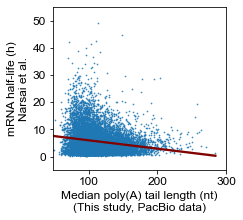

In [225]:
plt.figure(figsize=(3.1, 3))
sns.regplot(
    x="polya_len", 
    y="t1/2", 
    data=df,
    scatter_kws={'s' :.5},
    line_kws={'color': 'maroon'},
)
# plt.xlim(0, 300)
plt.ylim(-5, 55)
plt.xlabel('Median poly(A) tail length (nt)\n(This study, PacBio data)')
plt.ylabel('mRNA half-life (h)\nNarsai et al.')
plt.xticks([100, 200, 300])
# plt.xticks([0, 100, 200, 300])
# plt.yticks([0, 100, 200, 300])

In [226]:
infile = '/public/home/mowp/data/total_RNA/notebook/mRNA_half_life/TE.txt'
tpc_half_life = pd.read_csv(infile, sep='\t')
tpc_half_life['gene_id'] = tpc_half_life['gene_id'].str.upper()

In [227]:
df = pd.merge(nanopore_polya, tpc_half_life, on='gene_id')

In [229]:
pearsonr(df['polya_len'], df['TE'])

(-0.045554484844760504, 7.55631723270809e-10)